# Parametric shape optimization with differentiable FEM simulation


## Setup

In [1]:
# Install additional requirements for this notebook
# %pip install -r requirements.txt -q --isolated

In [2]:
# import tesseract_core

# tesseract_core.build_tesseract("sdf_fd_tess", "latest")
# tesseract_core.build_tesseract("fem_tess", "latest")
# tesseract_core.build_tesseract("meshing_tess", "latest")
# print("Tesseract built successfully.")

In [54]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from tesseract_core import Tesseract
from utils import (
    MMAOptimizer,
    hex_grid,
    plot_grid,
    plot_mesh,
)

from tesseract_jax import apply_tesseract

The Mapdl server and the spaceclaim tesseract are both running on a remote machine. Hence we define the host and URLs here.

In [8]:
spaceclaim_host = "172.26.3.35"
mapdl_host = spaceclaim_host

spaceclaim_port = 443
mapdl_port = 50052

spaceclaim_url = f"http://{spaceclaim_host}:{spaceclaim_port}"

## Design Space

First lets explore the design space.

In [9]:
design_tess = Tesseract.from_image("sdf_fd_tess")
design_tess.serve()

fem_tess = Tesseract.from_image("pymapdl_tess")
fem_tess.serve()

Now we can setup the parameters for the design space and apply the design Tesseract. The Tesseract constructs a 3D geometry using PyVista and computes its signed distance field (SDF). First lets define a few initial guesses for the parameter optimization.

In [21]:
grid_fin_params = {
    "plane_height": 400,
    "plane_thickness": 100,
    "cuttin_plane_1": 200,
    "cuttin_plane_2": 200,
}

grid_fins_star = [
    [(bar_idx - 4) * 0.2 + 3.14 / 2, (bar_idx - 4) * 0.2 + 3.14 / 2 + 3.14]
    for bar_idx in range(8)
]

grid_fins_grid = [
    0.84107417,
    5.44211113718,
    1.3466961,
    4.93648920718,
    1.7948966,
    4.48828870718,
    2.30051849,
    3.98266681718,
    0.19739674,
    2.94419591359,
    0.72972216,
    2.41187049359,
    6.08578856718,
    3.33898939359,
    5.55346314718,
    3.87131481359,
]

init_diffable_params_star = jnp.concatenate(
    [
        jnp.array(
            [grid_fin_params["cuttin_plane_1"], grid_fin_params["cuttin_plane_2"]]
        ),
        jnp.array(grid_fins_star).flatten(),
    ]
).astype(jnp.float32)

init_diffable_params_grid = jnp.concatenate(
    [
        jnp.array(
            [grid_fin_params["cuttin_plane_1"], grid_fin_params["cuttin_plane_2"]]
        ),
        jnp.array(grid_fins_grid).flatten(),
    ]
).astype(jnp.float32)


non_diffable_params = jnp.array(
    [
        grid_fin_params["plane_height"],
        grid_fin_params["plane_thickness"],
    ],
    dtype=jnp.float32,
)

In [22]:
Nx, Ny, Nz = 100, 80, 4
Lx, Ly, Lz = 50, 40, 2


normalization_factors = 1 / jnp.array([1000, 1000] + [3.14 * 2] * 16, dtype=jnp.float32)
normalization_bias = jnp.zeros_like(normalization_factors)


def normalize(params, norms, bias):
    return params * norms + bias


def denormalize(params, norms, bias):
    return (params - bias) / norms


init_diffable_params_star = normalize(
    init_diffable_params_star, normalization_factors, normalization_bias
)

init_diffable_params_grid = normalize(
    init_diffable_params_grid, normalization_factors, normalization_bias
)

design_inputs = {
    "non_differentiable_parameters": non_diffable_params,
    "normalization_factors": normalization_factors,
    "normalization_bias": normalization_bias,
    "static_parameters": [],
    "string_parameters": [
        "F:\\ANSYS Inc\\v242\\scdm\\SpaceClaim.exe",
        "geometry_generation.scscript",
    ],
    "mesh_tesseract": {"type": "url", "ref": spaceclaim_url},
    # the z coordinate of the object is not centered, hence we need to offset the SDF grid origin
    "grid_center": [0.0, 0.0, Lz / 2],
    "grid_size": [Lx, Ly, Lz],
    "grid_elements": [Nx, Ny, Nz],
    "scale_mesh": 0.01,
    "max_points": 1000,
    "max_faces": 2000,
    "precompute_jacobian": True,
    "normalize_jacobian": False,
    "sdf_backend": "pyvista",
    "epsilon": 0.001,
}

Lets obtain the star geometry from the design space.

In [23]:
design_out_star = apply_tesseract(
    design_tess,
    {
        "differentiable_parameters": init_diffable_params_star,
        **design_inputs,
    },
)
sdf_star = design_out_star["sdf"]
surface_mesh_star = design_out_star["mesh"]

num_vertices = surface_mesh_star["n_points"]
num_faces = surface_mesh_star["n_faces"]

print(f"Number of vertices: {num_vertices}")
print(f"Number of faces: {num_faces}")

points = surface_mesh_star["points"][:num_vertices]
faces = surface_mesh_star["faces"][:num_faces]

mesh_star = {
    "points": surface_mesh_star["points"][:num_vertices],
    "faces": surface_mesh_star["faces"][:num_faces],
}

Number of vertices: 224
Number of faces: 516


Using matplotlib and a helper function we can visualize the generated triangular mesh.

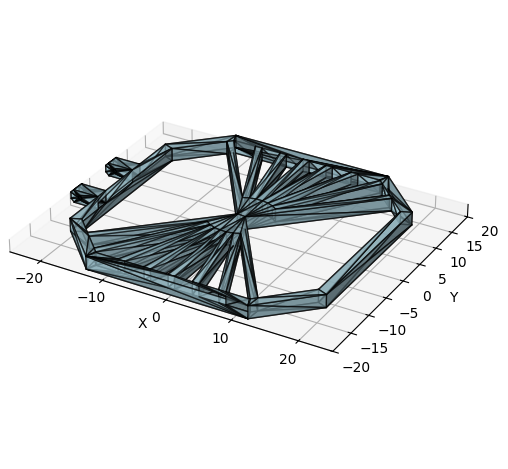

In [24]:
plot_mesh(mesh_star, [Lx, Ly, Lz], figsize=(8, 5))

And the corresponding signed distance field (SDF).

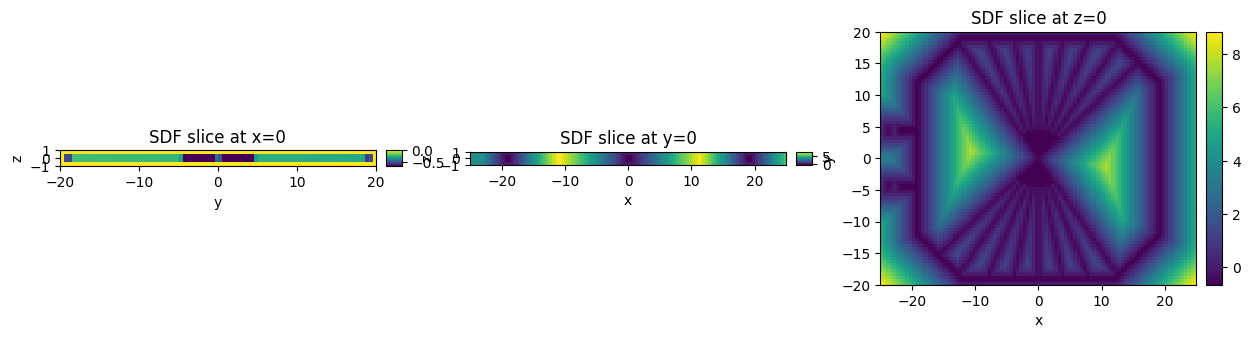

In [ ]:
plot_grid(sdf_star, Lx, Ly, Lz, Nx, Ny, Nz, "SDF")

Lets repeat the same for the grid like initialization.

In [25]:
design_out_grid = apply_tesseract(
    design_tess,
    {
        "differentiable_parameters": init_diffable_params_grid,
        **design_inputs,
    },
)
sdf_grid = design_out_grid["sdf"]
surface_mesh_grid = design_out_grid["mesh"]

num_vertices = surface_mesh_grid["n_points"]
num_faces = surface_mesh_grid["n_faces"]

print(f"Number of vertices: {num_vertices}")
print(f"Number of faces: {num_faces}")

points = surface_mesh_star["points"][:num_vertices]
faces = surface_mesh_star["faces"][:num_faces]

mesh_grid = {
    "points": surface_mesh_grid["points"][:num_vertices],
    "faces": surface_mesh_grid["faces"][:num_faces],
}

Number of vertices: 304
Number of faces: 712


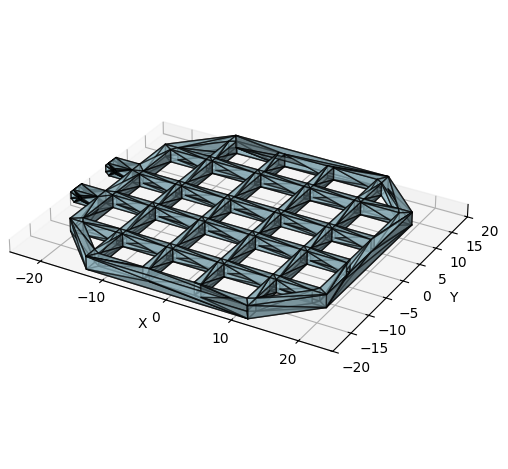

In [26]:
plot_mesh(mesh_grid, [Lx, Ly, Lz], figsize=(8, 5))

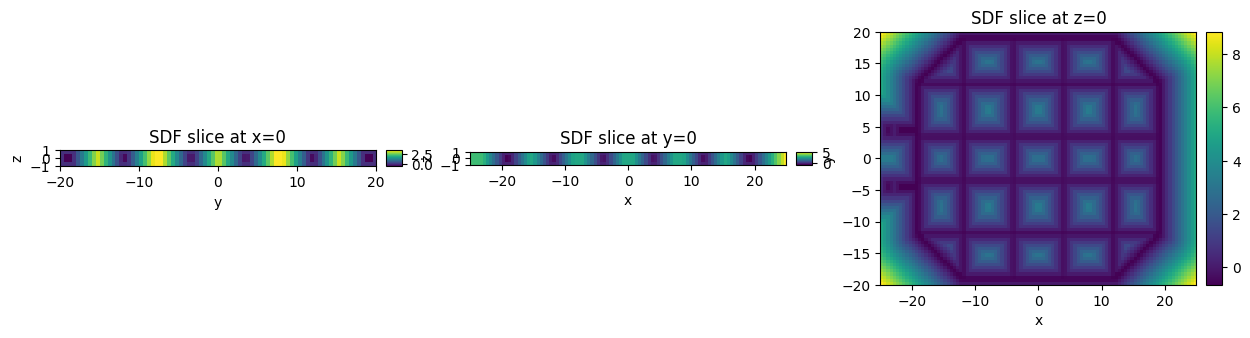

In [27]:
plot_grid(sdf_grid, Lx, Ly, Lz, Nx, Ny, Nz, "SDF")

## Density Variation

To generate a smooth density field from the SDF field, we define a specific function that uses a sigmoid internally.

rho min: 3.466034925736494e-08, rho max: 0.8621584177017212


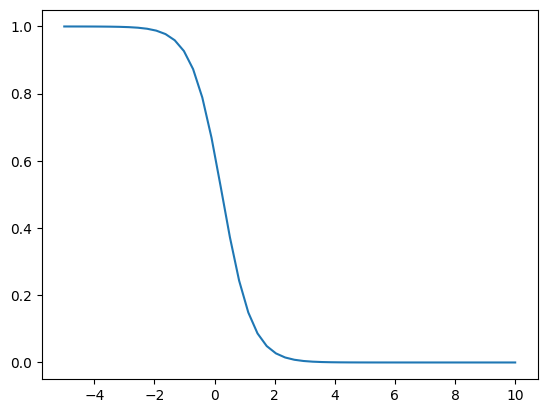

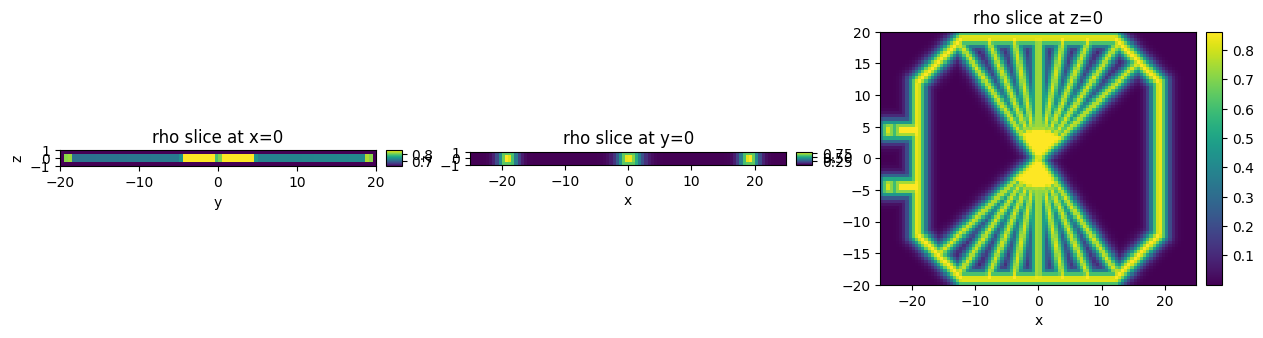

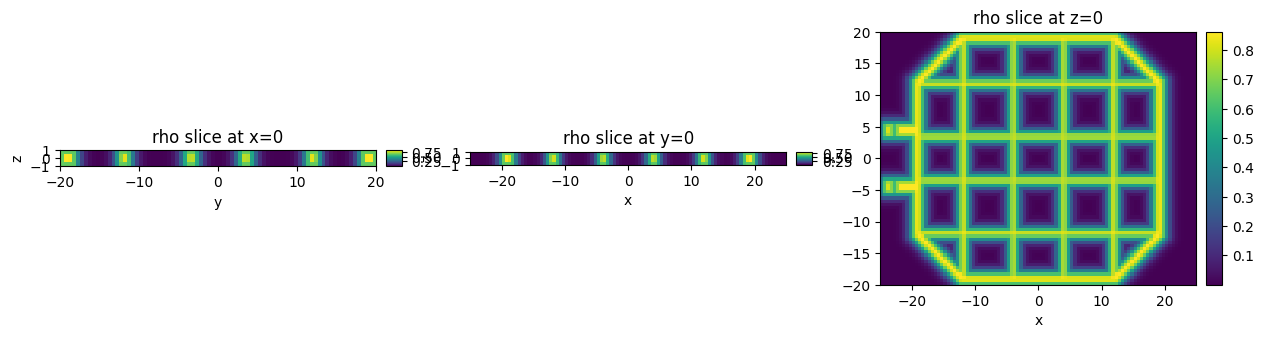

In [46]:
def sdf_to_rho(
    sdf: jnp.ndarray, scale: float = 2.0, offset: float = 0.1
) -> jnp.ndarray:
    """Convert signed distance function to material density using sigmoid.

    Args:
        sdf: Signed distance function values.
        scale: Sigmoid steepness (higher = sharper transition).
        offset: SDF value where density = 0.5.

    Returns:
        Material density field in [0,1].
    """
    return 1 / (1 + jnp.exp(scale * sdf - offset))


rho_scale = 2
rho_offset = 0.5

# plot the functions
sdfs = jnp.linspace(-5, 10)
rhos = sdf_to_rho(sdfs, scale=rho_scale, offset=rho_offset)

plt.plot(sdfs, rhos)


rho_star = sdf_to_rho(sdf_star, scale=rho_scale, offset=rho_offset)
rho_grid = sdf_to_rho(sdf_grid, scale=rho_scale, offset=rho_offset)

plot_grid(rho_star, Lx, Ly, Lz, Nx, Ny, Nz, "rho")
plot_grid(rho_grid, Lx, Ly, Lz, Nx, Ny, Nz, "rho")
print(f"rho min: {jnp.min(rho_star)}, rho max: {jnp.max(rho_star)}")

## Hex Mesh

As a next step, we create a hex mesh that is just a regular grid of voxel cells. Each density value is then associated with one cell in the grid.

In [34]:
points, cells = hex_grid(Lx, Ly, Lz, Nx + 1, Ny + 1, Nz + 1)

hex_mesh = {
    "points": points,
    "faces": cells,
    "n_points": jnp.array(points.shape[0]),
    "n_faces": jnp.array(cells.shape[0]),
}

We can look at the density values and the hex mesh cell center positions using a 3D scatter plot.

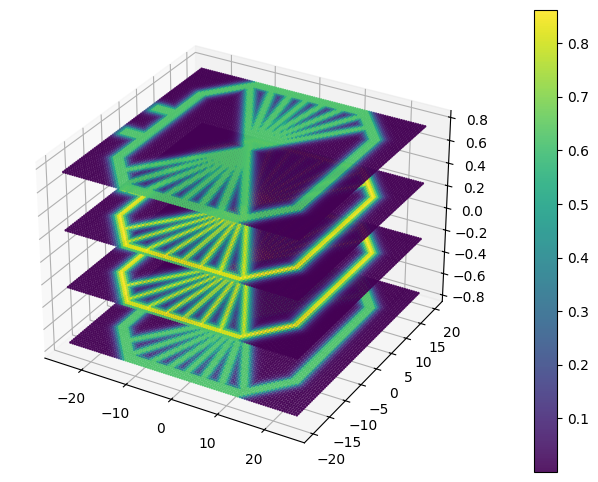

In [38]:
# lets make a scatter plot of the mesh cell values as colors
fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw={"projection": "3d"})
pts_coords = hex_mesh["points"]
hex_cells = hex_mesh["faces"]
center_points = jnp.mean(pts_coords[hex_cells], axis=1)
rho_mesh = rho_star.flatten()
scat = ax.scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=rho_mesh,
    s=1,
    alpha=0.9,
    cmap="viridis",
)
# colorbar
cbar = plt.colorbar(scat, ax=ax, pad=0.1)

## Boundary Conditions

In [ ]:
def get_boundary_masks(mesh: dict, Lx: float, Ly: float, Lz: float, sdf: jnp.ndarray):
    """Get boundary condition masks for the adaptive mesh.

    Args:
        mesh: Dictionary containing 'points' array.
        Lx: Size of the domain in x-direction.
        Ly: Size of the domain in y-direction.
        Lz: Size of the domain in z-direction.
        sdf: Signed distance field

    Returns:
        dirichlet_mask: Boolean array for Dirichlet boundary condition.
        van_neumann_mask: Boolean array for Van Neumann boundary condition.
    """
    pts = mesh["points"]

    dirichlet_mask = jnp.logical_and(
        pts[:, 0] <= -Lx / 2 + Lx / 12, sdf.flatten() < 0.5
    )
    von_neumann_mask = jnp.logical_and(
        jnp.isclose(pts[:, 0], (Lx / 2) - Lx / 7.6, atol=Lx / 64), sdf.flatten() < 0.5
    )

    return dirichlet_mask, von_neumann_mask


sdf_points = jnp.pad(sdf_star, [[0, 1], [0, 1], [0, 1]], mode="symmetric")
dirichlet_mask, von_neumann_mask = get_boundary_masks(hex_mesh, Lx, Ly, Lz, sdf_points)

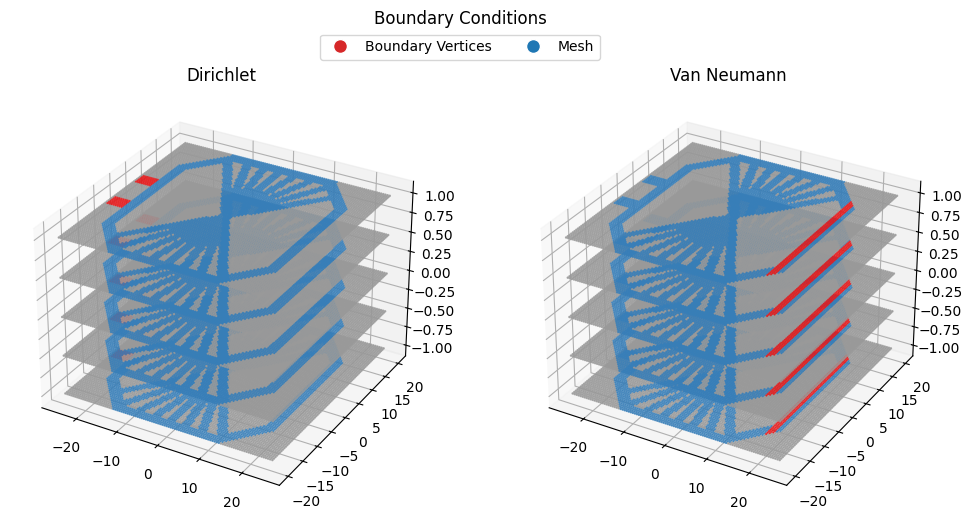

In [ ]:
fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))

plt.suptitle("Boundary Conditions")

sdf_points = jnp.pad(sdf_star, [[0, 1], [0, 1], [0, 1]], mode="symmetric")
base = jnp.where(sdf_points.flatten() < 0.5, 0.2, 0.6)

pts = hex_mesh["points"][: hex_mesh["n_points"]]

axs[0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(dirichlet_mask[: hex_mesh["n_points"]], 0.1, base),
    s=0.7,
    alpha=0.8,
    cmap="Set1",
)
axs[0].set_title("Dirichlet")

axs[1].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(von_neumann_mask[: hex_mesh["n_points"]], 0.1, base),
    s=0.7,
    alpha=0.8,
    cmap="Set1",
)
axs[1].set_title("Von Neumann")


# Create proxy artists for the legend
neumann_proxy = plt.Line2D(
    [0],
    [0],
    marker="o",
    color="w",
    label="Boundary Vertices",
    markerfacecolor="tab:red",
    markersize=10,
)
base_proxy = plt.Line2D(
    [0],
    [0],
    marker="o",
    color="w",
    label="Mesh",
    markerfacecolor="tab:blue",
    markersize=10,
)

# Add a single legend for the figure
fig.legend(
    handles=[neumann_proxy, base_proxy],
    loc="upper center",
    bbox_to_anchor=(0.5, 0.95),  # Adjust position as needed
    ncol=3,
)  # Number of columns in the legend

## Finite Element Analysis

In [ ]:
dirichlet_mask = dirichlet_mask.astype(jnp.int32)
von_neumann_mask = von_neumann_mask.astype(jnp.int32)

dirichlet_idx = jnp.where(dirichlet_mask)[0]
von_neumann_idx = jnp.where(von_neumann_mask)[0]
von_neumann_values = jnp.array([0, 0.0, 0.1]) / len(von_neumann_idx) + jnp.zeros(
    (von_neumann_idx.shape[0], 3)
)

fem_inputs = {
    "dirichlet_mask": dirichlet_idx,
    "dirichlet_values": jnp.zeros(dirichlet_idx.size),
    "van_neumann_mask": von_neumann_idx,
    "van_neumann_values": von_neumann_values,
    "hex_mesh": hex_mesh,
    "host": str(mapdl_host),
    "port": str(mapdl_port),
    "E0": 1.0,
    "rho_min": 1e-6,
    "log_level": "DEBUG",
    "vtk_output": "mesh_density.vtk",
}

Lets compute the compliance for both initial conditions.

In [47]:
fem_out_star = apply_tesseract(
    fem_tess,
    {"rho": jnp.expand_dims(rho_star.flatten(), axis=-1), **fem_inputs},
)

print(f"Compliance star: {fem_out_star['compliance']:.4f}")

Compliance star: 364.2391


In [48]:
fem_out_grid = apply_tesseract(
    fem_tess,
    {"rho": jnp.expand_dims(rho_grid.flatten(), axis=-1), **fem_inputs},
)

print(f"Compliance grid: {fem_out_grid['compliance']:.4f}")

Compliance grid: 148.0360


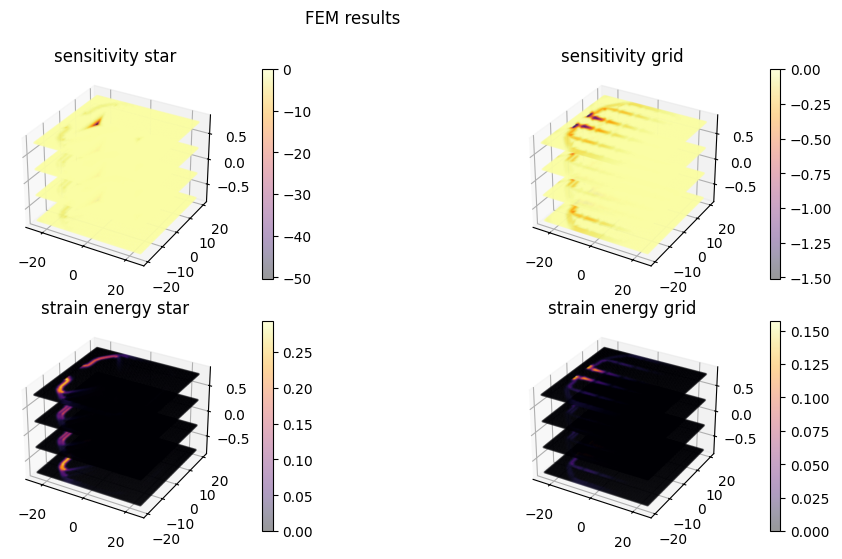

In [51]:
fig, axs = plt.subplots(2, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))
plt.suptitle("FEM results")

pts_coords = hex_mesh["points"]
hex_cells = hex_mesh["faces"]
center_points = jnp.mean(pts_coords[hex_cells], axis=1)

scat1 = axs[0, 0].scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=fem_out_star["sensitivity"],
    s=0.7,
    alpha=0.4,
    cmap="inferno",
)
axs[0, 0].set_title("sensitivity star")
cbar = plt.colorbar(scat1, ax=axs[0, 0], pad=0.1)

scat2 = axs[1, 0].scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=fem_out_star["strain_energy"],
    s=0.7,
    alpha=0.4,
    cmap="inferno",
)
axs[1, 0].set_title("strain energy star")
cbar = plt.colorbar(scat2, ax=axs[1, 0], pad=0.1)

scat1 = axs[0, 1].scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=fem_out_grid["sensitivity"],
    s=0.7,
    alpha=0.4,
    cmap="inferno",
)
axs[0, 1].set_title("sensitivity grid")
cbar = plt.colorbar(scat1, ax=axs[0, 1], pad=0.1)

scat2 = axs[1, 1].scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=fem_out_grid["strain_energy"],
    s=0.7,
    alpha=0.4,
    cmap="inferno",
)
axs[1, 1].set_title("strain energy grid")
cbar = plt.colorbar(scat2, ax=axs[1, 1], pad=0.1)

## Optimization Setup

In [52]:
from jax import custom_vjp

grad_storage = {}


def store_values(x, x_dot, hash_val: int):
    global grad_storage
    print("Storing values in hash", hash_val)
    grad_storage[int(hash_val)] = (x, x_dot)


@custom_vjp
def identity_and_store_grads(x, hash_val: int):
    return x


def identity_fwd(x, hash_val):
    return x, (x, hash_val)


def identity_bwd(residuals, g):
    x, hash_val = residuals
    jax.debug.callback(store_values, x, g, hash_val, ordered=False)
    return (g, None)


identity_and_store_grads.defvjp(identity_fwd, identity_bwd)

In [53]:
def loss(
    params: jnp.ndarray,
    iteration: int = 0,
) -> tuple[float, dict]:
    """Compute structural compliance for given bar parameters.

    Args:
        params: Bar parameter array with shape (n_chains, n_nodes, 3).
        iteration: current optim iteration.

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    # Generate signed distance field from design parameters
    design_out = apply_tesseract(
        design_tess,
        {
            "differentiable_parameters": params,
            **design_inputs,
        },
    )

    sdf = design_out["sdf"]
    sdf = identity_and_store_grads(sdf, iteration + 1000)

    # Convert SDF to material density distribution
    rho = sdf_to_rho(sdf, scale=rho_scale, offset=rho_offset)
    rho = identity_and_store_grads(rho, iteration + 2000)

    compliance = apply_tesseract(
        fem_tess,
        {"rho": jnp.expand_dims(rho.flatten(), axis=-1), **fem_inputs},
    )["compliance"]

    surface_mesh = {
        "points": design_out["mesh"]["points"][: design_out["mesh"]["n_points"]],
        "faces": design_out["mesh"]["faces"][: design_out["mesh"]["n_faces"]],
    }

    return compliance, {"sdf": sdf, "rho": rho, "surface_mesh": surface_mesh}


grad_fn = jax.value_and_grad(loss, has_aux=True)

By evaluating the loss, we look at the gradients at different stages of the workflow.


In [ ]:
# (loss_value, aux), grads = grad_fn(init_diffable_params_star, iteration=0)
# print(f"loss {loss_value}, grads {grads}")

Starting Jacobian precomputation thread...
Storing values in hash 2000
Storing values in hash 1000
Using precomputed Jacobian...
Waiting for Jacobian precomputation to finish...
Jacobian precomputation finished.
Jacobian shape: (18, 100, 80, 4) and type: float32
loss 178.7681884765625, grads [ 591.8795     -19.921665    90.00014    185.68532     20.96413
  196.06587      3.4130702  101.618935   -11.700733    32.99532
  -25.636398     9.005928   -45.071312     1.577271  -112.793884
  -20.43605    -72.513306   -31.77444  ]


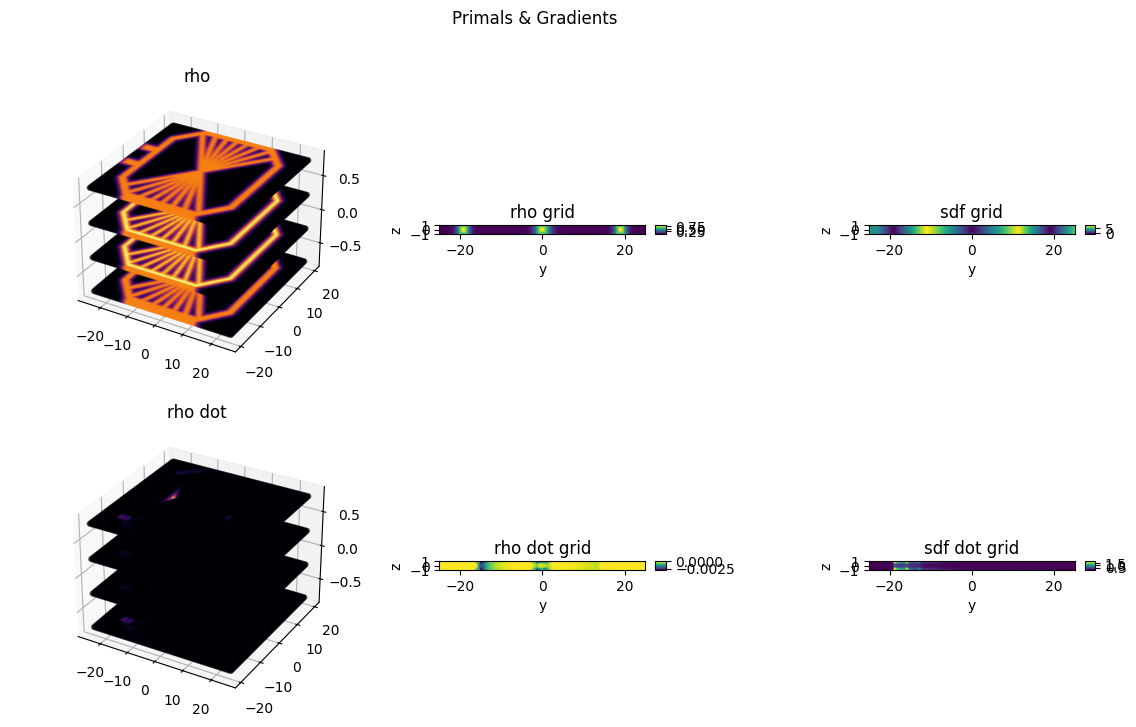

In [ ]:
# fig, axs = plt.subplots(2, 2, figsize=(14, 8))
# plt.suptitle("Primals & Gradients")

# mesh_star = hex_mesh

# pts_coords = mesh_star["points"]
# hex_cells = mesh_star["faces"]
# pts = jnp.mean(pts_coords[hex_cells], axis=1)

# plot_grid_slice(
#     aux["rho"][..., Nz // 2],
#     extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
#     ax=axs[0, 0],
#     title="rho grid",
#     xlabel="y",
#     ylabel="z",
# )

# plot_grid_slice(
#     grad_storage[2000][1][..., Nz // 2],
#     extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
#     ax=axs[1, 0],
#     title="rho dot grid",
#     xlabel="y",
#     ylabel="z",
# )

# plot_grid_slice(
#     aux["sdf"][..., Nz // 2],
#     extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
#     ax=axs[0, 1],
#     title="sdf grid",
#     xlabel="y",
#     ylabel="z",
# )

# plot_grid_slice(
#     grad_storage[1000][1][..., Nz // 2],
#     extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
#     ax=axs[1, 1],
#     title="sdf dot grid",
#     xlabel="y",
#     ylabel="z",
# )

# fig.subplots_adjust(wspace=0.0, hspace=0.4)

### Finite difference check

In [ ]:
# params = initial_params.copy()

# (loss_value, aux), grads = grad_fn(params, iteration=0)

# # Finite difference check
# run_central_difference = False
# num_tests = 3
# FD_delta = 1.0e-4
# FD_grads = 0 * jnp.array(grads)
# for i in range(num_tests):
#     print(i)
#     params_up = params.at[i].add(FD_delta)
#     fupp, _ = loss(params_up)

#     if run_central_difference:
#         params_down = params.at[i].subtract(2.0 * FD_delta)
#         fdown, _ = loss(params_down)
#         FD_grads = FD_grads.at[i].set((fupp - fdown) / FD_delta / 2.0)

#     else:
#         FD_grads = FD_grads.at[i].set((fupp - loss_value) / FD_delta)

# if num_tests > 0:
#     sens = jnp.array(grads[0:num_tests])
#     FD_sens = FD_grads[0:num_tests]
#     print(sens)
#     print(FD_sens)
#     errors = sens - FD_sens
#     print(errors)
#     rel_abs_error = jnp.abs(errors / sens)
#     if run_central_difference:
#         print(f"Relative error should be near O({FD_delta})")
#     else:
#         print(f"Relative error should be O({FD_delta * 10})")
#     print(rel_abs_error)

Starting Jacobian precomputation thread...
Storing values in hash 2000
Storing values in hash 1000
Using precomputed Jacobian...
Waiting for Jacobian precomputation to finish...
Jacobian precomputation finished.
Jacobian shape: (18, 100, 80, 4) and type: float32
0
Starting Jacobian precomputation thread...
1
Starting Jacobian precomputation thread...
2
Starting Jacobian precomputation thread...
[ 9.908102    0.62867576 -0.46080235]
[ 9.57489     0.45776367 -0.15258789]
[ 0.3332119   0.17091209 -0.30821446]
Relative error should be O(0.001)
[0.03363024 0.27186048 0.6688648 ]


## Design Optimization using MMA

In [62]:
def optimize(
    diffable_params: jnp.ndarray,
    iterations: int = 20,
    optimizer: str = "mma",
) -> tuple[list, list, list]:
    # set design bounds by a perturbation value 'delta'
    param_min = diffable_params.copy()
    param_max = diffable_params.copy()

    # the cutting planes do not change
    param_min = param_min.at[0].subtract(1.0e-3)
    param_min = param_min.at[1].subtract(1.0e-3)

    # the bars are free to rotate 2pi from their starting point
    theta_min = -2
    theta_max = 3
    for i in range(2, len(diffable_params)):
        param_min = param_min.at[i].set(theta_min)
        param_max = param_max.at[i].set(theta_max)

    # A placeholder is used for constraint
    num_constraints = 0
    g = jnp.zeros((0, 1))
    dgdx = jnp.zeros((0, diffable_params.shape[0]))

    # initialize the optimizer
    x_update_limit = 0.001  # 0.001 was okay, 0.01 was too much, 0.005 noisy but okay over 20 steps, 0
    params = diffable_params.copy()
    loss_hist = []
    params_hist = []
    aux_hist = []
    if optimizer == "mma":
        optimizer = MMAOptimizer(
            diffable_params[:, None],
            param_min[:, None],
            param_max[:, None],
            num_constraints,
            x_update_limit=x_update_limit,
        )
    elif optimizer == "adam":
        schedule = optax.exponential_decay(
            init_value=0.05,
            transition_steps=iterations,
            decay_rate=0.9,
            staircase=False,
        )
        optmizer = optax.adam(learning_rate=schedule)
        opt_state = optmizer.init(params)

    for i in range(iterations):
        (loss_value, aux), grads = grad_fn(params, iteration=i)
        print(f"params: {params}")
        print(f"grads: {grads}")

        if optimizer == "mma":
            np_params = optimizer.calculate_next_x(
                loss_value, grads, g, dgdx, i + 1, params
            )
            params = jnp.array(np_params.flatten())

        elif optimizer == "adam":
            grads = grads / jnp.max(grads)
            updates, opt_state = optmizer.update(
                grads, opt_state, params, value=loss_value, grad=grads, value_fn=loss
            )
            params = optax.apply_updates(params, updates)
            params = params.at[0:2].set(diffable_params[0:2])

        print(f"params after update: {params}")
        loss_hist.append(loss_value)
        params_hist.append(params)
        aux_hist.append(aux)

        print(f"Iteration {i + 1}, Loss: {loss_value:.4f}")

    return loss_hist, params_hist, aux_hist

Let us start a few iterations for different optimzation configurations.

In [63]:
loss_hist_grid_mma, params_hist_grid_mma, aux_hist_grid_mma = optimize(
    init_diffable_params_grid, iterations=5, optimizer="mma"
)

Storing values in hash 2000
Storing values in hash 1000
params: [0.2        0.2        0.133929   0.8665781  0.21444204 0.7860651
 0.28581154 0.71469563 0.36632457 0.6341826  0.0314326  0.468821
 0.11619779 0.3840558  0.96907455 0.5316862  0.88430935 0.6164513 ]
grads: [ 464.2652      18.573692    -6.405553     3.5292242  -14.391507
    6.4511533   -3.3785496  -14.179476    28.183813   -59.086063
   14.941439   -22.631111    67.16946   -493.63623    -16.620625
  -33.460613   -35.88269    452.81296  ]
params after update: [0.2        0.2        0.133929   0.8665781  0.21444204 0.7860651
 0.28581154 0.71469563 0.36632457 0.6341826  0.0314326  0.468821
 0.11619779 0.3840558  0.96907455 0.5316862  0.88430935 0.6164513 ]
Iteration 1, Loss: 148.0360
Storing values in hash 2001
Storing values in hash 1001
params: [0.2        0.2        0.133929   0.8665781  0.21444204 0.7860651
 0.28581154 0.71469563 0.36632457 0.6341826  0.0314326  0.468821
 0.11619779 0.3840558  0.96907455 0.5316862  0.8843

JaxRuntimeError: INTERNAL: CpuCallback error calling callback: Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/anaconda/envs/fem/lib/python3.13/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/kernelapp.py", line 758, in start
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tornado/platform/asyncio.py", line 211, in start
  File "/anaconda/envs/fem/lib/python3.13/asyncio/base_events.py", line 683, in run_forever
  File "/anaconda/envs/fem/lib/python3.13/asyncio/base_events.py", line 2050, in _run_once
  File "/anaconda/envs/fem/lib/python3.13/asyncio/events.py", line 89, in _run
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 701, in shell_main
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 469, in dispatch_shell
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 379, in execute_request
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 899, in execute_request
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 471, in do_execute
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/zmqshell.py", line 632, in run_cell
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3116, in run_cell
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3171, in _run_cell
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3394, in run_cell_async
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3639, in run_ast_nodes
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3699, in run_code
  File "/tmp/ipykernel_29441/25555562.py", line 1, in <module>
  File "/tmp/ipykernel_29441/2997165862.py", line 52, in optimize
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/traceback_util.py", line 180, in reraise_with_filtered_traceback
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/api.py", line 502, in value_and_grad_f
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/api.py", line 2194, in _vjp
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 315, in vjp
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 287, in linearize
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 255, in direct_linearize
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/linear_util.py", line 212, in call_wrapped
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/api_util.py", line 106, in flatten_fun_nokwargs2
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/api_util.py", line 292, in _argnums_partial
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/linear_util.py", line 421, in _get_result_paths_thunk
  File "/tmp/ipykernel_29441/2727648750.py", line 15, in loss
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_jax/primitive.py", line 384, in apply_tesseract
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 632, in bind
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 648, in _true_bind
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 660, in bind_with_trace
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 924, in process_primitive
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 1135, in fallback_linearize_rule
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 1169, in linearize_from_jvp
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/linear_util.py", line 212, in call_wrapped
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/linear_util.py", line 421, in _get_result_paths_thunk
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_jax/primitive.py", line 126, in tesseract_dispatch_jvp_rule
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 632, in bind
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 648, in _true_bind
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 660, in bind_with_trace
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/partial_eval.py", line 224, in process_primitive
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/partial_eval.py", line 233, in default_process_primitive
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 660, in bind_with_trace
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 1189, in process_primitive
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/dispatch.py", line 94, in apply_primitive
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/traceback_util.py", line 180, in reraise_with_filtered_traceback
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/pjit.py", line 263, in cache_miss
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/pjit.py", line 146, in _python_pjit_helper
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/pjit.py", line 1622, in _pjit_call_impl_python
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/profiler.py", line 359, in wrapper
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/pxla.py", line 1371, in __call__
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/callback.py", line 784, in _wrapped_callback
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_jax/primitive.py", line 208, in _dispatch
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_jax/tesseract_compat.py", line 160, in apply
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_core/sdk/tesseract.py", line 35, in wrapper
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_core/sdk/tesseract.py", line 325, in apply
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_core/sdk/tesseract.py", line 619, in run_tesseract
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_core/sdk/tesseract.py", line 539, in _request
  File "/anaconda/envs/fem/lib/python3.13/site-packages/requests/api.py", line 59, in request
  File "/anaconda/envs/fem/lib/python3.13/site-packages/requests/sessions.py", line 589, in request
  File "/anaconda/envs/fem/lib/python3.13/site-packages/requests/sessions.py", line 703, in send
  File "/anaconda/envs/fem/lib/python3.13/site-packages/requests/adapters.py", line 708, in send
  File "/anaconda/envs/fem/lib/python3.13/site-packages/urllib3/connectionpool.py", line 864, in urlopen
  File "/anaconda/envs/fem/lib/python3.13/site-packages/urllib3/connectionpool.py", line 535, in _make_request
  File "/anaconda/envs/fem/lib/python3.13/site-packages/urllib3/connection.py", line 565, in getresponse
  File "/anaconda/envs/fem/lib/python3.13/http/client.py", line 1447, in getresponse
  File "/anaconda/envs/fem/lib/python3.13/http/client.py", line 331, in begin
  File "/anaconda/envs/fem/lib/python3.13/http/client.py", line 292, in _read_status
  File "/anaconda/envs/fem/lib/python3.13/socket.py", line 723, in readinto
KeyboardInterrupt: 

In [ ]:
plt.plot(loss_hist_grid_mma, marker="o")
plt.yscale("log")
plt.xlabel("Optimization Iteration")
plt.ylabel("Compliance")
plt.title("Compliance over Optimization for grid using MMA")

In [61]:
loss_hist_grid_adam, params_hist_grid_adam, aux_hist_grid_adam = optimize(
    init_diffable_params_grid, iterations=5, optimizer="adam"
)

Storing values in hash 2000
Storing values in hash 1000
params: [0.2        0.2        0.133929   0.8665781  0.21444204 0.7860651
 0.28581154 0.71469563 0.36632457 0.6341826  0.0314326  0.468821
 0.11619779 0.3840558  0.96907455 0.5316862  0.88430935 0.6164513 ]
grads: [ 464.2652      18.573692    -6.405553     3.5292242  -14.391507
    6.4511533   -3.3785496  -14.179476    28.183813   -59.086063
   14.941439   -22.631111    67.16946   -493.63623    -16.620625
  -33.460613   -35.88269    452.81296  ]
params after update: [ 0.15000033  0.15000035  0.18392862  0.8165785   0.2644417   0.73606545
  0.33581114  0.7646953   0.31632492  0.6841822  -0.01856705  0.51882064
  0.06619813  0.43405545  1.0190742   0.58168584  0.934309    0.56645167]
Iteration 1, Loss: 148.0360


JaxRuntimeError: INTERNAL: CpuCallback error calling callback: Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/anaconda/envs/fem/lib/python3.13/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/kernelapp.py", line 758, in start
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tornado/platform/asyncio.py", line 211, in start
  File "/anaconda/envs/fem/lib/python3.13/asyncio/base_events.py", line 683, in run_forever
  File "/anaconda/envs/fem/lib/python3.13/asyncio/base_events.py", line 2050, in _run_once
  File "/anaconda/envs/fem/lib/python3.13/asyncio/events.py", line 89, in _run
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 701, in shell_main
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 469, in dispatch_shell
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 379, in execute_request
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 899, in execute_request
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 471, in do_execute
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/zmqshell.py", line 632, in run_cell
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3116, in run_cell
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3171, in _run_cell
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3394, in run_cell_async
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3639, in run_ast_nodes
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3699, in run_code
  File "/tmp/ipykernel_29441/1056501868.py", line 1, in <module>
  File "/tmp/ipykernel_29441/573885607.py", line 52, in optimize
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/traceback_util.py", line 180, in reraise_with_filtered_traceback
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/api.py", line 502, in value_and_grad_f
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/api.py", line 2194, in _vjp
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 315, in vjp
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 287, in linearize
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 255, in direct_linearize
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/linear_util.py", line 212, in call_wrapped
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/api_util.py", line 106, in flatten_fun_nokwargs2
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/api_util.py", line 292, in _argnums_partial
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/linear_util.py", line 421, in _get_result_paths_thunk
  File "/tmp/ipykernel_29441/2727648750.py", line 30, in loss
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_jax/primitive.py", line 384, in apply_tesseract
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 632, in bind
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 648, in _true_bind
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 660, in bind_with_trace
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 924, in process_primitive
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 1135, in fallback_linearize_rule
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 1169, in linearize_from_jvp
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/linear_util.py", line 212, in call_wrapped
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/linear_util.py", line 421, in _get_result_paths_thunk
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_jax/primitive.py", line 126, in tesseract_dispatch_jvp_rule
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 632, in bind
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 648, in _true_bind
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 660, in bind_with_trace
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/partial_eval.py", line 224, in process_primitive
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/partial_eval.py", line 233, in default_process_primitive
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 660, in bind_with_trace
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 1189, in process_primitive
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/dispatch.py", line 94, in apply_primitive
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/traceback_util.py", line 180, in reraise_with_filtered_traceback
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/pjit.py", line 263, in cache_miss
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/pjit.py", line 146, in _python_pjit_helper
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/pjit.py", line 1622, in _pjit_call_impl_python
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/profiler.py", line 359, in wrapper
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/pxla.py", line 1371, in __call__
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/callback.py", line 784, in _wrapped_callback
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_jax/primitive.py", line 208, in _dispatch
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_jax/tesseract_compat.py", line 160, in apply
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_core/sdk/tesseract.py", line 35, in wrapper
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_core/sdk/tesseract.py", line 325, in apply
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_core/sdk/tesseract.py", line 619, in run_tesseract
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_core/sdk/tesseract.py", line 539, in _request
  File "/anaconda/envs/fem/lib/python3.13/site-packages/requests/api.py", line 59, in request
  File "/anaconda/envs/fem/lib/python3.13/site-packages/requests/sessions.py", line 589, in request
  File "/anaconda/envs/fem/lib/python3.13/site-packages/requests/sessions.py", line 703, in send
  File "/anaconda/envs/fem/lib/python3.13/site-packages/requests/adapters.py", line 708, in send
  File "/anaconda/envs/fem/lib/python3.13/site-packages/urllib3/connectionpool.py", line 864, in urlopen
  File "/anaconda/envs/fem/lib/python3.13/site-packages/urllib3/connectionpool.py", line 535, in _make_request
  File "/anaconda/envs/fem/lib/python3.13/site-packages/urllib3/connection.py", line 565, in getresponse
  File "/anaconda/envs/fem/lib/python3.13/http/client.py", line 1447, in getresponse
  File "/anaconda/envs/fem/lib/python3.13/http/client.py", line 331, in begin
  File "/anaconda/envs/fem/lib/python3.13/http/client.py", line 292, in _read_status
  File "/anaconda/envs/fem/lib/python3.13/socket.py", line 723, in readinto
KeyboardInterrupt: 

In [ ]:
plt.plot(loss_hist_grid_adam, marker="o")
plt.yscale("log")
plt.xlabel("Optimization Iteration")
plt.ylabel("Compliance")
plt.title("Compliance over Optimization for grid using Adam")

In [ ]:
loss_hist_star_adam, params_hist_star_adam, aux_hist_star_adam = optimize(
    init_diffable_params_star, iterations=5, optimizer="adam"
)

In [ ]:
plt.plot(loss_hist_star_adam, marker="o")
plt.yscale("log")
plt.xlabel("Optimization Iteration")
plt.ylabel("Compliance")
plt.title("Compliance over Optimization for star using Adam")

In [ ]:
loss_hist_star_mma, params_hist_star_mma, aux_hist_star_mma = optimize(
    init_diffable_params_star, iterations=5, optimizer="mma"
)

In [ ]:
plt.plot(loss_hist_star_mma, marker="o")
plt.yscale("log")
plt.xlabel("Optimization Iteration")
plt.ylabel("Compliance")
plt.title("Compliance over Optimization for star using MMA")

### Optimization Postprocess

In [ ]:
# for i in range(len(loss_hist)):
#     mesh_star = hex_mesh
#     rho_dot = grad_storage[i + 2000][1][: len(mesh_star["faces"])]
#     pv_mesh = hex_to_pyvista(
#         mesh_star["points"],
#         mesh_star["faces"],
#         {"rho": aux_hist[i]["rho_grid"].flatten(), "rho_dot": rho_dot.flatten()},
#     )
#     pv_mesh.save(f"tmp_vtks/fem_shapeopt_mesh{i + 1}.vtk")

In [ ]:
# from matplotlib import animation

# fig = plt.figure(figsize=(7, 4))

# ims = []
# for aux in aux_hist:
#     sdf_star = aux["sdf"]

#     im = plt.imshow(
#         (sdf_star[:, :, :] > 0).sum(axis=2).T, origin="lower", cmap="viridis"
#     )
#     ims.append([im])

# ani = animation.ArtistAnimation(fig, ims, interval=10, blit=False, repeat_delay=2)
# plt.close(fig)

# ani.save("rho_fin_optim.gif", writer="pillow", fps=10)

In [ ]:
# # lets visualize the 3d meshes over the optimization
# for i, aux in enumerate(aux_hist):
#     plot_mesh(
#         aux["surface_mesh"],
#         save_path=f"tmp_img/mesh_optim_{i:03d}.png",
#         bounds=[Lx, Ly, Lz],
#     )

# images = []

# for i in range(n_steps):
#     filename = f"tmp_img/mesh_optim_{i:03d}.png"
#     images.append(imageio.imread(filename))
#     print(f"Added {filename} to gif.")
# # make sure the gif repeats forever
# imageio.mimsave("mesh_optim.gif", images, fps=10, loop=0)

In [ ]:
# for param in params_hist:
#     print(param)

[0.199999   0.19999999 0.11761145 0.6176114  0.14945862 0.6494586
 0.18130578 0.68130565 0.22315283 0.7131528  0.255      0.74499995
 0.2868471  0.7768472  0.31869423 0.81869423 0.35054138 0.8505413 ]
[0.199998   0.2        0.11261145 0.6126114  0.14445862 0.6444586
 0.18630578 0.67630565 0.21815284 0.7181527  0.26       0.73999995
 0.2918471  0.7818472  0.32369423 0.81369424 0.34554142 0.8555413 ]
[0.19999701 0.2        0.10761145 0.6076114  0.1494586  0.6394586
 0.18130578 0.68130565 0.22315283 0.7131527  0.255      0.74499995
 0.2968471  0.7768472  0.32869422 0.81869423 0.3505414  0.85054135]
[0.19999601 0.2        0.10261144 0.6026114  0.1444586  0.6344586
 0.18630578 0.67630565 0.21815284 0.7181527  0.26       0.73999995
 0.2918471  0.7818472  0.33369422 0.82369417 0.3555414  0.8555411 ]
[0.19999501 0.2        0.09761144 0.5976114  0.13945861 0.6294586
 0.18130578 0.67130566 0.22315283 0.7131527  0.255      0.74499995
 0.2968471  0.7768472  0.3386942  0.82869416 0.3605414  0.86054